# **Neuro RL** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TomGeorge1234/NeuroRLTutorial/blob/main/NeuroRL.ipynb)
## **University of Amsterdam Neuro-AI Summer School, 2024**
### made by: **Tom George (UCL) and Jesse Geerts (Imperial)**

<img src="./figures/tom.png" height=100><img src="./figures/jesse.png" height=100>
(↖ this is what we look like...find us wandering around if you have any questions!)

In this tutorial we'll study and build **reinforcement learning models inspired by the brain**. By the end you'll be able to construct a series of simple but surpringly powerful model of how agents and animals learn to navigate and make decisions in complex environments.

<center><img src="./figures/rl_animation.gif" width=500></center>

_Figure 1: An agent has learn to navigate around a wall towards a hidden reward using place cell state features and a simple Q-value learning algorithm. You'll make this in section 4_

### Exercises 

> 📝 **Exercise X.Y:** blah blah blah...

You should complete these exercises to the best of your ability.**[ADVANCED]** exercises are optional, intended only for those who feel comfortable with the material and want to push their understanding. 
- 🐍 Coding exercises always come with solutions hidden. To get the most out of this tutorial try to complete these yourselves before checking your solution. 
- 💭 Maths and/or discussion exercises have solutions which may or may not have been provided by your TA in a seperate notebook. 

## **Contents** 
0. [Import dependencies and data](#dependencies) 
1. [Rescorla-Wagner Model](#rescorla) (~60 mins)
    1. [Rescorla-Wagner with one conditioned stimulus](#rescorla_signlestim)
    2. [Rescorla-Wagner with multiple conditioned stimuli](#rescorla_multistim)
2. [Temporal Difference Learning](#td) (~60 mins)
    1. [Markov Reward Processes](#mrp)
    2. [Monte Carlo Learning](#montecarlo)
    3. [Temporal Difference Learning](#bootstrapping)
3. [Q-Values and Policy Improvement](#q) (~60 mins)
    1. [Markov Decision Processes](#mdp)
    2. [Q-Values](#qlearning)
    3. [SARSA](#sarsa)
    4. [Policy Improvement](#policyimprovement)
    5. [Policy Iteration](#policyiteration)
4. [State features and function approximation](#dqn) (~60 mins)
    1. [State features vs tabular states](#statefeatures)
    2. [Linear Q-Learning](#linearq)


---
## **0. Import dependencies and data** <a name="dependencies"></a>
Run the following code: It'll install some dependencies, download some files and import some functions. You can mostly ignore it. 

In [1]:
#@title Click to see code {display-mode: "form" }
!pip install wget ratinabox

# Importing the necessary libraries
import os
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import HTML # rendering animations
from tqdm import tqdm 

# RatInABox is used in section 4 to model continuous environments and state features
import ratinabox

# Download the utils if you don't already have them (e.g. if you're running this notebook on colab)
import wget 
if os.path.exists("NeuroRL_utils.py"):
    print("utils located")
    pass
else: 
    wget.download("https://github.com/TomGeorge1234/NeuroRLTutorial/raw/main/NeuroRL_utils.py")
    print("...utils downloaded!")
# This is a helper file that contains a lot of the functions used in this notebook
from NeuroRL_utils import *
%load_ext autoreload
%autoreload 2

utils located


---
## **1. Rescorla-Wagner** <a name="rescorla"></a>

Classical conditioning is where a neutral stimulus (the conditioned stimulus) is paired with a response-producing stimulus (the unconditioned stimulus). After the association is learned, the neutral stimulus *alone* can produce the response.
 
The most famous example is Pavlov's dogs: Pavlov rang a bell before feeding his dogs which would cause them to salivate. After a while, the dogs would start salivating when they heard the bell, even if no food was presented.

In 1972 Rescorla and Wagner proposed a simple model to explain this learning process. The model is based on the idea that the strength of the association between the CS and US is increased or decreased in proportion to the discrepancy between the predicted and actual US.

### **1.1. Model (maths)**<a name="rescorla_singlestim"></a>
Suppose the bell 🔔 is the conditioned stimulus, $S$, and the food 🦴 is the unconditioned stimulus with a response (reward) of strength $R$. The bell is paired with the food allowing an association to be learned.
$$ S\textrm{🔔} \rightarrow R\textrm{🦴} $$

Under the Rescorla-Wagner model, the goal is to learn the _value_ of the unconditioned stimulus:

$$ V(S) = \mathbb{E}[R] $$ 

We can "learn" this association by updating $\hat{V}(S)$ (our current _estimate_ of the value of the stimulus) based on the following simple learning rule: 

$$ \hat{V} \leftarrow \hat{V} + \alpha \cdot \underbrace{(R - \hat{V})}_{\delta = \textrm{``error"}}$$

This is Rescorla-Wagner: _"the increment in the value of a stimulus $S$ is proportional to the discrepancy between the reward (the unconditioned response) that was received, $R$, and the reward that was predicted from the stimulus, $\hat{V}(S)$."_  The proportionality constant $\alpha$ is the learning rate.

$\delta$ is often called the _prediction error_ and is one of the most key concepts in reinforcement learning. It is the discrepancy between what was expected and what was received. 
- Positive $\delta$ means the reward was better than expected, so the value of the stimulus should be increased.
- Negative $\delta$ means the reward was worse than expected, so the value of the stimulus should be decreased.

> 📝 **Exercise 1.1** 
> 1. 💭 Consider a simple example where there is only one stimulus with zero initial value. A constant reward, $R$ is given each trial. Show the value of the stimulus after the first trial is given by $V_1 = \alpha  \cdot R$.
> 2. 💭 **[ADVANCED]** Show that $\hat{V}_t = R \cdot (1 - e^{-\alpha\cdot t})$  (_Hint: you'll need to reformulate the update rule as an ODE and consider using the change of of variables $\delta(t) = R - \hat{V}_t$ and assume $\alpha$ is small_)

### **1.2 Model implementation (python)**

Below we provide some basic code implementing a Rescorla Wagner model with a learning rate of $\alpha = 0.1$ and an initial value estimate of $\hat{V}_0 = 0$ as 

```python
rescorlawagner = RescorlaWagner(alpha=0.1, initial_V=0)
```

Some initialisation logic and plotting functions are hidden away in the `BaseRescorlaWagner` class in `NeuroRL_utils.py`. What's matters to you is the following: 

**Attributes**
- `rescorlawagner.alpha`: is the learning rate, $\alpha$
- `rescorlawagner.V`: the current value estimate of the stimulus, $\hat{V}(t)$
- `rescorlawagner.V_history`: a list of the value of the stimulus at each trial, [$\hat{V}_0$, $\hat{V}_1$, ...]
- `rescorlawagner.R_history`: a list of the reward received at each trial, [$0$, $R_1$, $R_2$, ...] (the reward at trial 0 is always set to zero)

**Methods**
- `rescorlawagner.learn(R)`: updates the value of the stimulus based on the reward received <span style="color:red"> _[THIS FUNCTION NEEDS TO BE COMPLETED BY YOU]_ </span>
- `rescorlawagner.plot()`: plots the expected value of the stimulus over training time


> 📝 **Exercise 1.2:** 
> 
> 1. 🐍 Complete the `def learn(self, R):` function to implement the Rescorla-Wagner learning rule. Write the lines marked `????`


In [ ]:
class RescorlaWagner(BaseRescorlaWagner):
    def __init__(self, 
                 alpha=0.1, 
                 initial_V=0): 
        self.V = initial_V
        super().__init__(n_stimuli=1, alpha=alpha)

    def learn(self, R):
        raise NotImplementedError("You need to implement this method")
        # error = ????
        # self.V += ????
        # self.R_history.append(R) # include these lines to store the reward and value history
        # self.V_history.append(V) 

In [ ]:
#@title Click to see solution {display-mode: "form" }
def learn(self, R):
    error = R - self.V
    self.V += self.alpha * error
    self.R_history.append(R)
    self.V_history.append(self.V) 
RescorlaWagner.learn = learn # set the learn method to the function we just defined.

Now lets run an experiment where a reward of 1 is given each trial. We'll plot the value of the stimulus over time using the pre-written `RescorlaWagner.plot()` function.

In [ ]:
# Set your learning rate and reward
alpha = 0.1
R = 1

# Create the model
rescorlawagner = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(100):
    rescorlawagner.learn(R=np.random.normal(loc=1, scale=1))

> 📝 **Exercise 1.3**
>
> Print the past value of the stimulus at each trial and check it approaches 1 (the reward value).

In [ ]:
# Print the value history

In [ ]:
#@title Click to see solution {display-mode: "form" }
print(rescorlawagner.V_history)

> 📝 **Exercise 1.4**
>
> 1. 🐍 Plot the value history using the `ax = rescorlawagner.plot()` method. 
> 2. 🐍 On top of this, plot the theoretical solution you derived earlier (`ax.plot( ... )`) and check if it fits.

In [ ]:
# Your code here

In [ ]:
#@title Click to see solution {display-mode: "form" }
# Plot the results
ax = rescorlawagner.plot()
plt.close()

# Plot the analytic solution
t_range = np.arange(100)
V = R * (1 - np.exp(-t_range*alpha))
ax.plot(t_range, V, label='Analytic solution', linewidth=0.5, color='k', linestyle='--')
ax.legend()
ax.figure

> 📝 **Exercise 1.5**
>
> 1. 🐍 Adapt the above code so the reward is random each trial but has an expected value of 1 e.g. `R = np.random.normal(loc=1, scale=0.5)`. Plot the value history, does it still correctly converge to 1?

In [ ]:
#@title Click to see solution for random reward {display-mode: "form" }
alpha = 0.1

# Create the model
rescorlawagner = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(100):
    rescorlawagner.learn(R=np.random.normal(loc=1, scale=0.5))

# Plot the results
ax = rescorlawagner.plot()
ax.plot(t_range, V, label='Analytic solution', linewidth=0.5, color='k', linestyle='--')

> 📝 **Exercise 1.6**
> 
> 1. 🐍 **Acquisition:** Repeat the above experiment with a lower and a higher learning rate. What do you observe?
> 2. 💭 **TO THINK** Discuss the pros and cons of having a high or low reward rate. 
> 3. 🐍 **Extinction:** Repeat the above but this time reward is given only for the first 50 trials, then the reward is set to zero. What do you observe?


In [ ]:
# Your code for low learning rate acquisition goes here

In [ ]:
#@title Click to see solution {display-mode: "form" }
# Set your learning rate and reward
alpha = 0.5
R = 1

# Create the model
RW = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(100):
    RW.learn(R=R)

# Plot the results
ax = RW.plot()
ax.set_title("Higher learning rate")

In [ ]:
# Your code for high learning rate acquisition goes here

In [ ]:
#@title Click to see solution {display-mode: "form" }
# Set your learning rate and reward
alpha = 0.05
R = 1

# Create the model
RW = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(100):
    RW.learn(R=R)

# Plot the results
ax = RW.plot()
ax.set_title("Lower learning rate")

In [ ]:
# Your code for extinction goes here

In [ ]:
#@title Click to see solution {display-mode: "form" }
# Set your learning rate and reward
alpha = 0.1

# Create the model
RW = RescorlaWagner(alpha=alpha)

# Run the model
for trial in range(50):
    RW.learn(R=1)
for trial in range(50): #remove the reward
    RW.learn(R=0)

# Plot the results
ax = RW.plot()
ax.set_title("Extinction experiment")

### **1.3. Rescorla-Wagner with multiple  stimuli**<a name="rescorla_multistim"></a>

It's easy to extend the Rescorla-Wagner model to multiple stimuli:

* Stimuli are now represented by vectors. If there are two possible stimuli we can use a 2D vector e.g.:  
    * Stimulus A: $\mathbf{s} =[1, 0]$ 
    * Stimulus B: $\mathbf{s} =[0, 1]$
    * Stimulus A & B: $\mathbf{s} =[1, 1]$
    * Stimulus A weakly and B strongly: $\mathbf{s} =[0.1, 1.0]$
    * ...etc. 

* A vector of association "weights", $\mathbf{w}$, denotes the strength of the association between each stimulus and the unconditioned response (i.e. the value of each stimulus). 
    * $\mathbf{w} = [w_1, w_2]$.
* The total value of the stimuli is the sum of the values of each stimulus present on a given trial: 
$$ \hat{V}(\mathbf{s}) = \mathbf{s} \cdot \mathbf{w}  = s_1 \cdot w_1 + s_2 \cdot w_2$$

The full Rescorla-Wagner model is then:
$$\mathbf{w} = \mathbf{w} + \alpha \big(R - \hat{V}(\mathbf{s})\big) \cdot \mathbf{s}$$

> 📝 **Exercise 1.7**
>
> 1. 💭 Reason why $\mathbf{s}$ now appears in the learning rule.

> 📝 **Exercise 1.8**
> 
> 1. 🐍As before, complete the `def learn(self, R, S):` function to implement the Rescorla-Wagner learning rule for multiple stimuli.

In [ ]:
class RescorlaWagner_multistim(BaseRescorlaWagner):
    def __init__(self, n_stimuli=2, alpha=0.1, initial_value=0): 
        self.W = np.zeros(n_stimuli)
        super().__init__(n_stimuli=n_stimuli, alpha=alpha)

    def learn(self, S, R):
        raise NotImplementedError("You need to implement this method")
        # V = ????  # calculate the value of the stimuli, 
        # error = # ???? # calculate the error
        # self.W += # ???? # update the weights

        # store the history (leave these lines in)
        self.W_history = np.vstack([self.W_history, self.W])
        self.R_history.append(R)
        self.V_history.append(S @ self.W)
        self.S_history.append(S)


In [ ]:
#@title Click to see solution {display-mode: "form" }
def learn(self, S, R):
    V = S @ self.W # calculate the value of the stimuli
    error = R - V # calculate the error
    self.W += alpha * S * error # update the weights

    # store the history
    self.W_history.append(self.W.copy())
    self.R_history.append(R)
    self.V_history.append(S @ self.W)
    self.S_history.append(S)

# Set the learn method to the function we just defined.
RescorlaWagner_multistim.learn = learn

**Exercise 1.9**:
1. 🐍 With your partner implement these four experiments in the Rescorla-Wagner model:
    1. **Blocking**
        * A single stimulus is paired with the US (A --> R), then a compound stimulus is paired with the US (AB --> R). What happens?
    2. **Overshadowing**
        * Two stimuli are paired with a reward (AB --> R) but one is much more salient than the other, e.g. $\mathbf{s} = [1, 0.1]$.
    3. **Overexpectation**
        * Two stimuli are seperately paired with the US (A --> R, B --> R), then the compound stimulus is presented (AB --> ?). What do you observe?
    4. **Conditioned Inhibition**
        * A single stimulus is paired with the US (A --> R) then a second stimulus is added and the reward is removed. (AB --> _). What do you observe?

In [ ]:
# Your code for the blocking experiment goes here

In [ ]:
#@title Double click to see solution {display-mode: "form" }
rescorla_blocking = RescorlaWagner_multistim(n_stimuli=2, alpha=0.1)
for i in range(50):
    rescorla_blocking.learn(S=np.array([1,0]), R=1)
for i in range(50):
    rescorla_blocking.learn(S=np.array([1,1]), R=1)

rescorla_blocking.plot()

Let's break down this plot: 

* The **top** plot shows the stimuli which were present on each trial. Their transparency denotes their strength. 
* The **middle** plot shows the association weights of the stimuli.
* The **bottom** plot shows the total predicted value of the presented stimuli $\hat{V}(\mathbf{s}) = \mathbf{s}\cdot\mathbf{w}$ along with the actual reward received on each trial.


In [ ]:
# Your code for the overshadowing experiment goes here

In [ ]:
#@title Double click to see solution {display-mode: "form" }
rescorla_overshadowing = RescorlaWagner_multistim(n_stimuli=2)
for i in range(100):
    rescorla_overshadowing.learn(S=np.array([0.9, 0.1]), R=1)
ax = rescorla_overshadowing.plot()
ax[0].set_title("Overshadowing")

In [ ]:
# Your code for the overexpectation experiment goes here

In [ ]:
#@title Double click to see solution {display-mode: "form" }
rescorla_overexpectation = RescorlaWagner_multistim(n_stimuli=2)
for i in range(50):
    rescorla_overexpectation.learn(S=np.array([1, 0]), R=1)
for i in range(50):
    rescorla_overexpectation.learn(S=np.array([0, 1]), R=1)
for i in range(50):
    rescorla_overexpectation.learn(S=np.array([1, 1]), R=1)
ax = rescorla_overexpectation.plot()
ax[0].set_title("Overexpectation")

In [ ]:
# Your code for the inhibition experiment goes here

In [ ]:
#@title Double click to see solution {display-mode: "form" }
rescorla_inhibition = RescorlaWagner_multistim(n_stimuli=2)
for i in range(50):
    rescorla_inhibition.learn(S=np.array([1, 0]), R=1)
for i in range(50):
    rescorla_inhibition.learn(S=np.array([1, 1]), R=0)
ax = rescorla_inhibition.plot()
ax[0].set_title("Inhibition")

> 📝 **Exercise 1.10**
>
> 1. 🐍 Starting from the inhibition experiment above, extend it so that the reward prediction goes negative.
> 2. 🐍 Simulate a conditioning experiment with three stimuli, where the first two are paired with the US and the third is not. What do you observe?

In [ ]:
#Your code for the negative reward prediction experiment goes here

In [ ]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_multistim(n_stimuli=2)
for i in range(50):
    RW.learn(S=np.array([1, 0]), R=1)
for i in range(50):
    RW.learn(S=np.array([1, 1]), R=0)
for i in range(50):
    RW.learn(S=np.array([0, 1]), R=1)
ax = RW.plot()
ax[0].set_title("Negative reward prediction")

In [ ]:
# Your code for three stimuli goes here

In [ ]:
#@title Double click to see solution {display-mode: "form" }
RW = RescorlaWagner_multistim(n_stimuli=3)
for i in range(10):
    RW.learn(S=np.array([1, 0, 0]), R=1)
for i in range(10):
    RW.learn(S=np.array([1, 1, 0]), R=1)
for i in range(10):
    RW.learn(S=np.array([1, 1, 1]), R=1)
ax = RW.plot()
ax[0].set_title("Three stimuli")

> 📝 **Exercise 1.11**
> 
> 1. 💭 TO THINK The Rescorla Wagner model fails to capture some aspects about animal conditioning. The following are _three real observations_ about conditioning in the brain. Out of these three which _would_ the Rescorla Wagner model you've built be able to capture and which wouldn't it capture. 
> 
>    1. A stimulus that has repeatedly been experienced alone, without a reward, is subsequently less effective at conditioning than a novel stimulus.
>    2. If an inhibitory stimulus (i.e. one with a negative association weight) is presented on its own, without any response, it's association strength will remain stable and negative. 
>    3. If one stimulus is paired with a reward and then another is additionally introduced it will be "blocked" from learning (we already this model). Then, when the reward is subsequently removed, the association strength of the first stimulus will begin decreasing but not the second. 

---
## **2. Temporal difference learning** <a name="td"></a>

One limitation of the Rescorla-Wagner model is that it doesn't take into account the temporal structure of the environment. Associations are made between stimuli _now_ and rewards _now_. In reality, rewards are often delayed. 

### **2.1. Markov Reward Processes**<a name="mrp"></a>

For this we must consider temporally evolving "Markov Reward Processes" where states progress through time and may (or may not) return rewards.

$$ S_{0} \rightarrow R_{1}, S_{1} \rightarrow R_{2}, S_{2} \rightarrow R_{3}, \ldots $$

In a Markov reward process, the state transitions and rewards may be probabilistic (later we'll consider Markov "Decision" processes where transitions may depend on "actions"). The "value" of a state is the expected sum of rewards that will be received in the future, starting from that state.

$$V(S_t) = \mathbb{E} \big[ \underbrace{R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots}_{G_t = \textrm{``return'' from state $_{S_t}$}}\big]$$

This differs from Rescorla-Wagner only in that the value of a state is not just based on the reward received _now_ ($V(S_t) = \mathbb{E} [R_{t+1} ]$) but also on the rewards that will be received in the future.

$\gamma$ is the discount factor, typically set near or just less than 1. This factor ensures that rewards received in the future are "worth" less than rewards received now. This is generally a wise assumption since rewards in the future are less certain (_"a bird in the hand is worth two in the bush"_).

> 📝 **Exercise 2.1**
>
> 1. 💭 Calculate the value of each state in the following MRP (let $\gamma = 0.9$): 
>    $$ S_0 \rightarrow R_1=1, S_1 \rightarrow R_2=2, S_2 \rightarrow R_3=3, S_3 \rightarrow R_4=4, S_4 \rightarrow R_5=5 (\textrm{episode ends}) $$
> 2. 💭 **[ADVANCED]** Calculate the value of east state in the following recursive and continuous MRP:
>    $$ S_0 \rightarrow R_1=1, S_1 \rightarrow R_2=1, S_0 \rightarrow R_3=1, S_1 \rightarrow R_4=1, S_0 \rightarrow R_5=1, S_1 \rightarrow R_6=1, \ldots $$
> 3. 💭 **TO THINK** In a continuous task (one where the Markov process continue indefinitely and never end) why might a discount factor $\gamma = 1$ be a problem? 

As before our goal is to learn an estimate of the value of each state, $\hat{V}(S) \leftarrow V(S)$.

#### **2.1.1 Tabular vs. Function Approximation**

When there are multiple stimuli (or states) in an environment you have a choice. Either:
1. **Tabular**: You can store the value of each state in a big table (tabular learning) 
$$ \hat{V}(S_t) = [ \hat{V}(S_0), \hat{V}(S_1), \ldots, \hat{V}(S_{N_{\textrm{states}}}) ] $$
2. **Function Approximation**: You can learn a _function_ that maps states (typically represented by a feature vector) to values.
\begin{align}
\hat{V}_{\textrm{generic}}(\mathbf{s}) & = f(\mathbf{s}; \theta)  \hspace{4cm} \\
\hat{V}_{\textrm{linear}}(\mathbf{s}) & = \mathbf{w} \cdot \mathbf{s}  \\
\hat{V}_{\textrm{2-layer NN}}(\mathbf{s})& = \phi(\mathbf{W}_{2}\cdot(\phi(\mathbf{W}_1 \cdot \mathbf{s} + \mathbf{b}_1) + \mathbf{b}_2 )   \\
& = \ldots
\end{align}

Both have advantages and disasvantages: 
- Tabular methods are typically simpler and have better convergence gaurantees. 
- Function approximation scales better to much larger state spaces, is more biologically plausible and can generalize better to unseen states.

We used a linear function approximation in the Rescorla-Wagner model with multiple stimuli. This was because we wanted to be able to represent multiple stimuli _simultaneously_ which is difficult to do with a tabular method.

> 📝 **Exercise 2.2**
>
> 1. 💭 **TO THINK** Convince yourself that linear function approximation -- where states are represented by one-hots 
>    $$\mathbf{s}(S_1) = [1,0,0,\ldots], \mathbf{s}(S_2) = [0,1,0,\ldots], \ldots$$ 
>     is equivalent to the tabular method where $\mathbf{w} = [V(S_1), V(S_2), \ldots]$. 
>
>    Remember, although _this_ particular function approximation scheme is trivially equivalent to tabular, we'll see examples later which definitely are not. 

For now we'll revert back to tabular methods and consider function approximation again in section 4.

> 📝 **Exercise 2.3**
>
> 1. 💭 **[ADVANCED]** By considering the following loss function $L_t = \big[ \hat{V}(S_t) - V(S_t) \big]^2$ show, by gradient descent in $\hat{V}(S_{t})$, that the optimal update rule for $\hat{V}(S_t)$ is $\hat{V}(S_t) \leftarrow \hat{V}(S_t) + \alpha \big[ V(S_t) - \hat{V}(S_t) \big]$

### **2.2 Monte-Carlo learning**<a name="montecarlo"></a>
One way to estimate the value of a state is to wait until the end of each episode, collecting all the rewards that were received along the way, and then calculate the single-episode return $G_t$ for each state and use this as a target. 

$$ \hat{V}(S_t) \leftarrow \hat{V}(S_t) + \alpha  \big[ G_t - \hat{V}(S_t) \big] $$

Since the _expectation_ of $G_t$ is equal to $V(S_t)$ this update is equivalent to performing _stochastic gradient descent_ of the loss function and is called **Monte-Carlo learning**. 

Although in theory this does work, in practice, Monte-Carlo learning is often infeasible because it requires waiting until the end of each episode to update the value of each state. 

This turns out to be quite a serious limitation in real-world applications - imagine waiting until the end of a game of chess to update the value of each state! Or worse, some environments don't have a clearly defined end such as the game of life we're all currently playing. 

This is where bootstrapping and temporal difference learning comes in...

### **2.3 Bootstrapping the value of a state with Temporal Difference learning**<a name="bootstrap"></a>
The key idea behind TD-learning is to estimate the value of a state by bootstrapping from the value of the next state. 

> 📝 **Exercise 2.4**
>
> 1. 💭 Show that the value of a state can be written as the sum of the reward received at that state and the value of the next state. i.e.
> $$V(S_t) = \mathbb{E} [R_t + \gamma V(S_{t+1})]. $$

This is called the _Bellman equation_ and is the basis of TD-learning. It encodes a _very_ important idea: 

**Bellman Equation:  The future value of a state now is equal to the reward received now plus the value of the next state (discounted a little bit).**

It gives us a clue for how we can bypass the need to wait until the end of each episode to update the value of each state. Instead, we can just update the value of each state based on the reward received and the value of the next state (no waiting required).

But wait! How do we know the value of the next state? We don't, that's what we're learning. So we'll use our current estimate of the value of the next state, $\hat{V}(S_{t+1})$ as a _proxy_.

$$V(S_t) = \mathbb{E} [\color{red}{\underbrace{R_t + \gamma V(S_{t+1})}_{\textrm{I don't know this}}} \color{d}{}] \approx  \mathbb{E}[\color{green}{\underbrace{R_t + \gamma \hat{V}(S_{t+1})}_{\textrm{I do know this}}}\color{d}{}] $$

This gives us the TD-learning update rule:

$$\hat{V}(S_t) \leftarrow \hat{V}(S_t) + \alpha \big[\underbrace{R_t + \gamma \hat{V}(S_{t+1}) - \hat{V}(S_t)}_{\delta_t = \textrm{``TD-error''}} \big]$$

The term $\delta_t$ is the _temporal difference error_. It can be high (low) for two reasons: 
1. The reward was better (or worse) than expected.
2. The value of the next state was higher (or lower) than expected.

The second point is crucial: even though we might not observe reward in a given state we may still assign this state value because the _next_ state has value. This is called _bootstrapping_. It's the same reason you might be happy to have received an invitation to a job interview even though interviews aren't inherently fun - you're bootstrapping from the value of the next state (potentially being offered a job).

> 📝 **Exercise 2.5**
>
> 1. 🐍 Implement the TD-learning update rule in the `def learn(self, R, S, S_next, alpha):` function in the `TDLearner` class below.

In [2]:
class TDLearner(BaseTDLearner):
    def __init__(self, gamma=0.5, alpha=0.1, n_states=10):
        self.gamma = gamma
        self.alpha = alpha
        self.V = np.zeros(n_states)
        super().__init__(gamma=gamma, alpha=alpha, n_states=n_states)
        
    def learn(self, S, S_next, R):
        raise NotImplementedError("You need to implement this method")
        # Get's the value of the current and next state
        V = self.V[S]             if S is not None else 0
        V_next = self.V[S_next]   if S_next is not None else 0
        
        # Calculates the TD error (hint remember to use self.gamma
        # TD_error = # ???

        # Updates the value of the current state
        # if S is not None:
            # self.V[S] = # ???

        #  return TD_error

In [3]:
#@title Click to see solution {display-mode: "form" }
def learn(self, S, S_next, R):
    # Get's the value of the current and next state
    V = self.V[S]              if S is not None else 0
    V_next = self.V[S_next]    if S_next is not None else 0
    
    # Calculates the TD error 
    TD_error = R + self.gamma * V_next - V

    # Updates the value of the current state
    if S is not None:
        self.V[S] = self.V[S] + self.alpha * TD_error
        
    return TD_error

TDLearner.learn = learn

### **2.4 Training a TD-Learner on a sequence of states** 

Now we're going to train the TD learner in a simple markov reward process environment. We'll use the following class method (already written for you, not shown)

- `TDLearner.learn_episode(states, rewards)` takes a list of `states` = $[S_0, S_1, \ldots, S_T]$ and  `rewards` = $[R_1, R_2, \ldots, R_{T+1}]$ and trains the TD-learner on this sequence of states and rewards by calling the `learn` method at each time step. It then saves the results to history. 

_**Note** behind the scenes this method appends as state $S_{-1} = $ `None` and reward $R_0 = 0$ to the start of the sequence. This represents the initial state and reward before the first state is observed, and it cannot be predicted (it will be useful in exercise 2.8.3))_

For example, an MRP where states deterministically progress from 0 to 1 to ... to 9 and receiving a reward of zero except at state 9 where a reward of 1 is received can be simulated as follows:

```python
TD.perform_episode(
    states  = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
    rewards = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
)
```

> 📝 **Exercise 2.6**
>
> 1. 🐍 Simulate 100 episodes of the above MRP (let $\alpha = 0.5$ and $\gamma = 0.9$) then use the `TDLearner.plot(episode=0)` method to show the results after the first and last episode. 

In [ ]:
#@title Click to see solution {display-mode: "form" }
# Set some parameters 
n_episodes = 50
gamma = 0.90
alpha = 0.5 # for now use a high learning rate
n_states = 10

# Initialize the TD learner
tdlearner = TDLearner(gamma=gamma, n_states=n_states, alpha=alpha)

# Generate the MRP 
states = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
rewards = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

# Run the experiment
for episode in range(n_episodes):
    tdlearner.learn_episode(
        states=states,
        rewards=rewards,)

# Plot the results
anim = tdlearner.animate_plot()
HTML(anim.to_jshtml()) # uncomment this line to see the animation (may take a while to render)

Lets discuss these plot: 

- The **top-left** plot shows the states (y-axis) visited across time (x-axis)
- The **top-right** plot shows the current state value estimate at each episode. 
- The **bottom** plots shows the reward received at each state and the TD error at each state.

> 📝 **Exercise 2.7**
>
> 1. 💭 After learning has converged, what is the value of state 0? 
> 2. 💭 Approximately how "fast" does the value bump move backwards? How does this relate to the notion of one-step bootstrapping. 
> 3. 💭 Why does a residual TD-error accumulate at the start? Understanding this is important for understanding TD-learning.
> 1. 💭 **TO THINK** Look at the figure below showing the firing of dopamine neurons in the brain responding initially to the reward and then to earlier and earlier reward-predicting stimuli. Discuss the similarities and differences between the backward movement of TD error in your model and the backward movement of dopamine firing in the brain. 
> 2. 🐍 **[ADVANCED]** Perhap you noticed that the TD spreads out as it moves backwards. Think about why this happens, play around with the learning rate $\alpha$ and see if this changes things. 

<center>
<img src="./figures/td_dopamine.png" width=500>
</center>

> 📝 **Exercise 2.8**
>
> 1. 💭  What would happen to the TD error if a small positive reward is given at the end (as we just simulated) and then, after learning has converged, the reward is removed? _Hint: think about what happens in the brain, and why_.
> 2. 💭 Calculate the TD error which would be observed in the terminal state $S=9$ the first instance the reward is removed. 
> 3. 🐍 Simulate this experiment. 
> 4. 💭 **TO THINK** Discuss the similarities between this and the following figure showing the firing of dopamine neurons in the brain when a previously stable reward is removed.

<center>
<img src="./figures/td_noreward.png" width=300>
</center>

In [ ]:
# Your code goes here

In [ ]:
#@title Click to see solution {display-mode: "form" }
# Set some parameters 
n_episodes = 40
gamma = 0.90
alpha = 0.5 
n_states = 10

# Initialize the TD learner
tdlearner = TDLearner(gamma=gamma, n_states=n_states, alpha=alpha)

# Generate the MRP 
states = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
rewards = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
later_rewards = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Run the experiment
for episode in range(n_episodes):
    tdlearner.learn_episode(
        states=states,
        rewards=rewards,)
# Run the experiment
for episode in range(n_episodes):
    tdlearner.learn_episode(
        states=states,
        rewards=later_rewards,) # the end reward has been removed

# Animating the results
anim = tdlearner.animate_plot()   
HTML(anim.to_jshtml())

> 📝 **Exercise 2.9 [ADVANCED]**
> 
> 1. 🐍 What happens if this environment is stochastic? Adapt the code to model the following very stochastic environment...
>
>   - **State transitions are now probabilistic**: 
>        - As before there are $N = 10$ states from $i=0$ to $i=N-1$.
>        - When the agent is in state $S_t = i$ it has a probability $p_t = 0.8$ of moving to state $S_{t+1} = i+1$ and a 0.2 probability of staying in state $S_{t+1} = i$. 
>       - The agent starts in state $S =0$ and episode ends whenever the agent reaches state $S=N-1=9$.
>
>   - **Rewards are probabilistic** as a function of the state: 
>        - When the agent is in state $S_t = i$ a reward is _randomly_ drawn from a normal distribution $R_t = R(S_t=i) \sim \mathcal{N}(\mu=(i+1) / N, \sigma=1)$. 
>
>      Simulate 200 episodes(let $\gamma = 0.8$ and $\alpha = 0.1$) of this new MRP and plot or animate the results.
>
> 2. 💭 Though stochastic, there is an _exact_ solution to the value of each state in this environment. Can you derive it? 
> You'll want to start from the Bellman equation $V(S_t) = \mathbb{E} [R_t + \gamma V(S_{t+1})]$ and show the expected value of the last state $S = N-1$ is 1.0 then derive the following recursion relation:
> $$ V(N-1) = 1$$
> $$ V(n) = \frac{1}{1 - \gamma (1-p_t)} \left( \frac{n + 1}{N} + \gamma p_t \cdot V(n+1) \right) $$ 
>

In [ ]:
# Your code goes here...it may be useful to copy the code above and modify it

In [ ]:
#@title Click to see solution (warning: may take up to a minute to animate) {display-mode: "form" }
# # Set some parameters 
n_episodes = 200
gamma = 0.8
alpha = 0.05
n_states = 10
p_transition = 0.8 

# Initialize the TD learner
tdlearner = TDLearner(gamma=gamma, n_states=n_states, alpha=alpha)


# Run the experiment
for episode in range(n_episodes):
    # Generate the MRP 
    states = np.array([0])
    rewards = np.array([0])
    while states[-1] != 9:
        # Stochoastic transition
        if np.random.rand() < p_transition: state_next = states[-1] + 1
        else: state_next = states[-1]
        # Stochoastic reward
        reward = np.random.normal(loc=(states[-1]+1) / n_states)
        rewards = np.append(rewards, reward)
        states = np.append(states, state_next)
    tdlearner.learn_episode(
        states=states,
        rewards=rewards,)

# NEW Here we calculate the theoretical value estimates and set them to be plotted
theoretical_value = np.zeros(n_states)
for i in range(n_states)[::-1]:
    if i == n_states - 1:
        theoretical_value[i] = 1 
    else:
        theoretical_value[i] = (1 / (1 - gamma * (1 - p_transition))) * (((i + 1)/n_states) + gamma * p_transition * theoretical_value[i+1])
tdlearner.theoretical_value = theoretical_value #this will plot the theoretical value onto the animation 


# Plot the results
anim = tdlearner.animate_plot()
HTML(anim.to_jshtml())

The dotted line `---` on the value curve (top right) now displays the theoretical solution.

**Observation:** Even though the environment is highly stochastic the _expected_ value of each state is well defined. With a small learning rate the TD learner can learn a stable estimate of this expected value essentially smoothing over the stochasticity. If you repeat this experiment with a higher learning rate, you'll see the value estimates are much more noisy.

> 📝 **Exercise 2.10** 
> 
> 1. 💭 TO THINK: Discuss how this observation relates to learning in the brain. 

---
## **3. Q-Values and Policy Improvement** <a name="q"></a>

So far we have only considered environments where there is no choice. The agent is simply moving through a sequence of states it has no control over. In the real world agents have choices (called _actions_).

For this we need to introduce the idea concept of a _policy_. A policy is any function which maps states to actions, actions then determine how one state leads to another. Policies are often denoted by $\pi$:

$$ \pi : S \rightarrow A $$

A _Markov reward process_ (MRP) where the agent has a policy is called a _Markov Decision Process_ (MDP).

$$ S_0 \xrightarrow{A_0 \sim \pi(S_0)} R_1, S_1 \xrightarrow{A_1\sim \pi(S_1)} R_2, S_2 \xrightarrow{A_2\sim \pi(S_2)} R_3, S_3 \xrightarrow{A_3\sim \pi(S_3)} R_4, S_4 \xrightarrow{A_4\sim \pi(S_4)} \ldots $$

The _action_ the agent took at each state determines the state the agent ends up in next which may (or may not) come with a reward.

### **3.1 Q-Values**<a name="qvalues"></a>

The "value'' of a state now depends not just on the state but on the action taken in that state and the policy that was followed thereafter. 

Q-values represent a natural generalisation of the state value of a state-action pair under a policy: 

$$ Q_{\pi}(s, a) = \mathbb{E}_{\pi} \big[ R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \ldots \big| S_t = s, A_t = a \big] $$

In plain English this say: "$Q_{\pi}(s, a)$ is the expected return from taking action $a$ in state $s$ and then following policy $\pi$.". Note the expectation is over $\pi$ because the policy determines the future actions, states and rewards. The policy (which actions are taken in which states) and the environment (which states and rewards are reached from which states) could _both_ be stochastic.

Like the value of a state, the Q-values satisfy the Bellman equation:

$$ Q_{\pi}(s, a) = \mathbb{E}_{\pi} \big[ R_{t+1} + \gamma Q_{\pi}(S_{t+1}, A_{t+1}) \big| S_t = s, A_t = a, A_{t+1}\sim\pi(S_{t+1}) \big] $$

> 📝 **Exercise 3.1 [ADVANCED]**
>
> <center> <img src="./figures/mdp.png" width=300> </center>
>
> 1. 💭 Consider the above simple MDP where there are two states ($S_1$ and $S_2$) and two actions ($A_1$ and $A_2$).
>       - $S_1$: taking action $A_1$ leads to $S_2$ with reward 2, taking action $A_2$ leads back to $S_1$ with reward 1.
>       - $S_2$: taking action $A_1$ leads to $S_1$ with reward 3, taking action $A_2$ leads back to $S_2$ with reward 1.
> 
>    1. 💭 Given the policy $\pi_1$ where $\pi_1(S_1) = A_1$, $\pi(S_2) = A_2$, what are the Q-values of each state-action pair under this policy (it might help to calculate them in the following order)?
>       * $Q_{\pi_1}(S_2, A_2)$
>       * $Q_{\pi_1}(S_1, A_1)$
>       * $Q_{\pi_1}(S_1, A_2)$
>       * $Q_{\pi_1}(S_2, A_1)$
>
>    2. 💭 Write down the optimal policy $\pi^*$ (Hint: don't overthink it) 
>       * $\pi^*(S_1) = ?$
>       * $\pi^*(S_2) = ?$
>
>    3. 💭 What are the Q-values of each state-action pair under the optimal policy $\pi^*$?
>       * $Q_{\pi^*}(S_1, A_1)$
>       * $Q_{\pi^*}(S_2, A_2)$
>       * $Q_{\pi^*}(S_1, A_2)$
>       * $Q_{\pi^*}(S_2, A_1)$

### **3.2 SARSA**<a name="sarsa"></a>

Not all MDPs are  simple enough to solve analytically like the example above. In practice we often use _learning algorithms_ to estimate the Q-values from observations. 

The closest equivalent learning rule to TD-learning rule for Q-values is:

$$\hat{Q}_{\pi}(S_t, A_t) \leftarrow \hat{Q}_{\pi}(S_t, A_t) + \alpha \big[ R_{t+1} + \gamma \hat{Q}_{\pi}(S_{t+1}, A_{t+1}) - \hat{Q}_{\pi}(S_t, A_t) \big]$$

This is often called the SARSA learning rule because it takes into account the **S**tate $S_t$, the **A**ction $A_t$, the **R**eward $R_{t+1}$, the next **S**tate $S_{t+1}$ and the next **A**ction $A_{t+1}$.

Note how it looks almost identical to the TD-learning rule for state values but with the addition of the action terms. 

#### **3.2.1 SARSA implementation**

Let's adapt or `TDLearner` class into a `TDQLearner` to learn Q-values. It's very simple, we just need to... 

1. ...change `self.V` (a list) to `self.Q` (an array) to store Q-values for each state-action pair. 
    - `self.Q[s, a]` is the Q-value of state `s` and action `a`.
2. ...change the `learn()` method to update Q-values instead of state values. I.e. instead of 
    - `self.learn(S, S_next, R)` updating `self.V[S]`...
    - `self.learn(S, S_next, A, A_next, R)` should update `self.Q[S, A]`.

> 📝 **Exercise 3.2**
>
> 1. 🐍 Complete the missing lines (those with `????`) in the `def learn(self, S, S_next, A, A_next, R, alpha):` function in the `TD_QValueLearner` class below.


In [14]:
class TDQLearner(BaseTDQLearner):
    def __init__(self, gamma=0.5, alpha=0.1, n_states=10, n_actions=2):
        self.Q = np.zeros((n_states, n_actions))
        self.n_actions = n_actions
        super().__init__(gamma=gamma, alpha=alpha, n_states=n_states)
  
    def learn(self, S, S_next, A, A_next, R):
        # Get's the value of the current and next state
        raise NotImplementedError("You need to implement this method")
        # Q = # ???? # get the value of the current state (remember it's zero if S is None)
        # Q_next = # ???? # get the value of the next state
         
        # Calculates the TD error (hint remember to use self.gamma
        # TD_error = # ???? # calculate the TD error

        # Updates the value of the current state
        # if S is not None:
        #     self.Q[S,A] = # ???? # update the Q value

        # return TD_error

In [15]:
def learn(self, S, S_next, A, A_next, R):
    # Get's the value of the current and next state
    Q = self.Q[S,A] if S is not None else 0
    Q_next = self.Q[S_next, A_next] if S_next is not None else 0
    
    # Calculates the TD error (hint remember to use self.gamma
    TD_error = R + self.gamma * Q_next - Q

    # Updates the value of the current state
    if S is not None:
        self.Q[S,A] = Q + self.alpha * TD_error 

    return TD_error
TDQLearner.learn = learn

> 📝 **Exercise 3.3**
> 
> 1. 🐍 Perform the following experiment: Each episode, with a 50:50 probability, is either a "Left" episode or a "Right" episode:
>       - **"Right":** Agent moves to the right from $S=0$ to $S=9$ (action $A = 0$), receiving a reward ($R=1$) at the terminal state.
>       - **"Left"**: Agent moves to the left from $S=9$ to $S=0$ (action $A = 1$), receiving a negative reward ($R=-1$) at the terminal state.
> 2. 🐍 Once simulated, plot the Q-values (stored in `TD_QValueLearner.Q`) of each state-action pair. What difference do you observe between the Q-values of _the same two states_ under the two different actions? 

In [ ]:
# Complete this code 
gamma = 0.90 # discount factor
alpha = 0.5 # learning rate
n_episodes = 100

# Make the TDQ learner
tdqlearner = TDQLearner(gamma=gamma, alpha=alpha, n_states=10, n_actions=2)

for episode in range(n_episodes):
    
    # randomly choose between a left or right episode
    episode_type = np.random.choice(['left', 'right'])

    # write code which generates the states, actions and rewards for the episode and then performs the episode

In [ ]:
#@title Click to see solution {display-mode: "form" }
gamma = 0.90 # discount factor
alpha = 0.5 # learning rate
n_episodes = 100

# Make the TDQ learner
tdqlearner = TDQLearner(gamma=gamma, alpha=alpha, n_states=10, n_actions=2)

for episode in range(n_episodes):
    
    # randomly choose between a left or right episode
    episode_type = np.random.choice(['left', 'right'])

    if episode_type == 'right':
        states = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        actions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        rewards = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    elif episode_type == 'left':
        states = np.array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])
        actions = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
        rewards = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, -1])
    
    tdqlearner.learn_episode(
        states=states,
        actions=actions,
        rewards=rewards)

In [ ]:
# Write code to plot the Q values 

In [ ]:
#@title Click to see solution {display-mode: "form" }
Q_values = tdqlearner.Q
fig, ax = plt.subplots(1,1 , figsize=(4,2))
ax.bar(np.arange(10), Q_values[:,0], color='C0', label='Action = 0 ("Right")', alpha=0.5)
ax.bar(np.arange(10), Q_values[:,1], color='C1', label='Action = 1 ("Left")', alpha=0.5)
ax.axhline(0, color='k', linewidth=0.5)
ax.set_xlabel('State')
ax.set_ylabel('Q-value')
ax.legend() 


### **3.3 Policy Improvement**<a name="policyimprovement"></a>

So far we have learnt about: 
1. **Rewards:** How to associate states with rewards by minimising a prediciton error (Rescorla-Wagner)
2. **Values:** How to associate a _state_ with future rewards by learning it's value (TD-learning)
3. **Q-Values** How to evaluate a _policy_ by calculating the Q-value of taking each action in each state (SARSA). 

The final pillar of model-free reinforcement learning is **Policy Improvement**. 

4. **Policy Improvement** Use `<some-algorithm>` to (iteratively) improve the policy towards the optimal policy. 


The _optimal_ policy (which we'd like to find) is defined as the one which maximises the expected returns from each state:
$$ \pi^* = \arg\max_{\pi} Q_{\pi}(s, a) \hspace{3mm} \forall \hspace{3mm}s, a$$

In general, this is _very_ hard to find and doing so often requires a lot of computation. The examples we'll see today are relatively simple but still may require several hundred to thousands of episodes to converge.

There two main families of algorithms for finding optimal policies in RL:
1. **Policy-based methods**: Learn the policy function directly, for example using a neural network to map states to actions (example: _REINFORCE_, or _Actor-Critic_ methods). We will not be covering these methods in this tutorial.
1. **Value-based methods**: Learn the Q-values and then derive the policy from the Q-values.

#### **3.3.1 Greedy policy**

So how do we use $Q_{\pi}(s,a)$ to improve the policy? Suppose we define a new policy 

$$ \textrm{Greedy policy:}\hspace{1cm}\pi^{\prime}(s) = \arg\max_a Q_{\pi}(s, a) $$

A very important theorem in RL called the _policy improvement theorem_ states that $\pi^{\prime}$ is guaranteed to be _as good as or better than_ $\pi$, in all states. 

That is...if we know the Q-values of a given policy we can find a new policy which will return at least as much reward, if not more, in all states by simply choosing the action with the highest Q-value.

This is an immensely powerful result and, although we won't prove it today, it's easy to intuitively understand why it's true: if you know the value of each action in each state you can simply choose the best one!

#### **3.3.2 Exploration vs. Exploitation**

There's one problem with the greedy policy: it's greedy! It always chooses the action with the highest Q-value. This is great if you know the Q-values perfectly but in practice you often don't.

In practice you need to balance _exploration_ (trying new things) with _exploitation_ (doing what you know works). This is a fundamental trade-off in reinforcement learning and is a key challenge in designing reinforcement learning algorithms.

One simple way to do this is to use an $\epsilon$-greedy policy. This is a policy which with probability $1-\epsilon$ chooses the greedy action and with probability $\epsilon$ chooses a random action. 

$$ \epsilon \textrm{-greedy policy:}\hspace{1cm}\pi^{\prime}(s) = \begin{cases}
\arg\max_a Q_{\pi}(s, a) & \textrm{with probability } 1-\epsilon \\
\textrm{random action} & \textrm{with probability } \epsilon
\end{cases}$$


### **3.4 Policy Iteration**<a name="policyiteration"></a>

So we know how to evaluate a policy with an algorithm such as SARSA, and we know how to improve a policy by taking the greedy action in each state. Now all we need to do is to combine these two steps in an iterative algorithm called _policy iteration_.

1. Evaluating the policy (learning the Q-values under the policy)
2. Improving the policy (using the Q-values to derive a new policy)

<center><img src="./figures/policy_iteration.png" width=400></center>


> 📝 **Exercise 3.4**
>
> 1. 💭 The exploitation-exploration trade-off is a key challenge in reinforcement learning. Can you think of a real-world example where this trade-off is important?
> 2. 💭 In a stable environment which you know well and is not subject to change, would it be better to prioritise exploration or exploitation? Can you think of an example of such an environment in the real world?
> 3. 💭 What about in an unstable environment which you don't know well and is constantly changing?
> 4. 💭 Greedy policies are always deterministic. Can you think of some real-world examples where a stochastic policy might be optimal? Note: we are not referring to examples where exploration helps you to learning in an uncertain system, but where a stochastic policy is fundamentally optimal even once you know the system as well as possible.
> 5. 💭 Can you think of a different way to balance exploration and exploitation other than $\epsilon$-greedy? 

### **3.4 Grid world**<a name="gridworld"></a>

In the following section we're going to construct a simple grid world environment and train a TD-learner to learn the Q-values of each state-action pair then use policy iteration to derive the optimal policy.

#### **3.4.1 Initialising a grid world environment**

```python
minigrid = MiniGrid(
    grid = grid, # a numpy array representing the grid world
    reward_locations = [(6,6),], # a list of tuples representing the location of rewards
    reward_values = [1,] # a list of the reward values at each location
    )
```
The agent will automatically be initialised in a random position. 

The two most important functions you will write are are: 
1. `policy(state, Q_values)` which returns an action.
2. `minigrid.step(action)` which takes an action and returns the next state and reward and whether the episode has ended.

#### **3.4.2 Indexing grid world states and actions (boring but important)**
The "state" is the position of the agent in the 2D environment: 
* `minigrid.agent_pos --> (x,y) tuple` e.g. `(3,4)` is the 3rd grid from the left, fourth grid from the bottom. 
* `minigrid.pos_to_state(pos) --> int` a unique single integer representing the state, for a 10 x 5 grid this would be `(9-minigrid.agent_pos[1]) * 10 + minigrid.agent_pos[0]`.

There are four possible actions:
* `0` = move North, `1` = move East, `2` = move South, `3` = move West.

Some other useful methods and attributes:
* `minigrid.reset()` resets the agent to a random position.
* `minigrid.pos_to_state(pos)` converts a position tuple to a state index.
* `minigrid.is_wall(pos)` returns `True` if the position is a wall.
* `minigrid.is_reward(pos)` returns the reward value found at the position.
* `minigrid.n_states` the number of states in the environment.
* `minigrid.n_actions` the number of actions in the environment.

Plotting functions: 
* `minigrid.render()` renders the current state of the environment.
* `minigrid.plot_Q(Q)` plots the Q-values of each state-action pair.
* `minigrid.plot_episode(episode : int)` plots the `episode`_th episode from the history. 
* `minigrid.plot_policy(Q)` plots the optimal (greed) policy derived from the Q-values.
* `minigrid.plot_training()` shows smoothed episode length against episode number.

The following code generates a small grid world ,play around a bit to get a feel for how it works. 

Black squares represent wall, green circle is the agent, and the orange circle is the reward


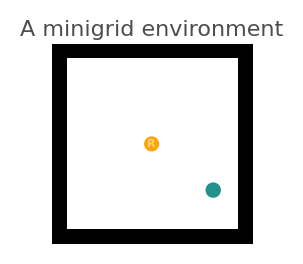

In [4]:
grid = np.array( # 0 = empty, 1 = wall
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],        
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ])

environment = MiniGrid(
    grid = grid,
    reward_locations = [(6,6),],
    reward_values = [1,]
    )

ax = environment.render()
ax.set_title("A minigrid environment")
print("Black squares represent wall, green circle is the agent, and the orange circle is the reward")

> 📝 **Exercise 3.5**
>
> 1. 🐍 Write the `minigrid.step` function for the grid world environment. The rules of the environment should be as follows: 
>       - If the agent steps into a wall it should stay in the same place and receive a reward of -1. Use `minigrid.cost_per_wall_collision` so that this can be easily changed later.
>       - If the agent steps into the goal it should receive the reward associated with that goal and the episode should end.
>       - Otherwise the agent should receive a reward of -0.1 (cost of moving around). Use `minigrid.cost_per_step` so that this can be easily changed later.
> 2. 💭 TO THINK Discuss why a slightly negative cost to movement is useful to 
>       - encourage the agent to find the _shortest_ path to the goal
>       - encourage the agent to explore the environment early on when Q-values are initialised to zero. 

In [5]:
def step(self, action : int):
    """This function must have a very specific signature to work with the MiniGrid environment. 
    1. It must update the self.agent_pos attribute tuple from (x, y) to (x_new, y_new) based on the action
    2. It must return the following tuple (state, reward, is_terminal) where:
        - state is the new agent position (x_new, y_new)
        - reward is the reward at the new agent position
        - is_terminal is a boolean indicating if the agent has reached the terminal state. 
    
    It might make sense to break it down into two steps: 
    (i) propose a new position based on the action
    (ii) check if the new position is a wall or reward then update the agent position return the reward and terminal status. 
    """
    raise NotImplementedError("You need to implement the step method")
    
    # Propose a new position based on the action
    proposed_new_pos = None # write this 

    # Check if the new position is a wall or reward 
    is_wall = self.is_wall(proposed_new_pos) # returns True if the proposed new position is a wall
    if not is_wall:
        self.agent_pos = proposed_new_pos
    
    # Check if the new position is a reward
    reward = self.get_reward(proposed_new_pos) # returns any reward found at the proposed new position
    is_terminal = (reward > 0) # If a reward is found then the episode is over
    reward += None # consider adding other contributions to the reward from moving costs or hitting walls

    # Get the new state 
    state = self.pos_to_state(self.agent_pos)

    return self.agent_pos, reward, is_terminal 

MiniGrid.step = step

In [6]:
#@title Click to see solution {display-mode: "form" }
def step(self, action):
    # Propose a new position based on the action
    proposed_new_pos = None # write this 
    if action == 0:   delta = (0,1) # North
    elif action == 1: delta = (1,0) # East
    elif action == 2: delta = (0,-1) # South
    elif action == 3: delta = (-1,0) # West
   
    # Get the proposed next position by adding the delta to the current position
    proposed_new_pos = np.array(self.agent_pos) + np.array(delta)
    proposed_new_pos = tuple(proposed_new_pos)

    # Check if the new position is a wall or reward 
    is_wall = self.is_wall(proposed_new_pos) # returns True if the proposed new position is a wall
    if not is_wall:
        self.agent_pos = proposed_new_pos
        self.agent_direction = action

    # Check if the new position is a reward
    reward = self.get_reward(proposed_new_pos) # returns True if the proposed new position is a reward
    is_terminal = (reward > 0) # If a reward is found then the episode is over
    reward -= self.cost_per_step # cost of moving (defaults to 0.1)
    if is_wall: reward -= self.cost_per_wall_collision # cost of hitting a wall(defaults to 1)

    # Get the new state 
    state = self.pos_to_state(self.agent_pos)

    return state, reward, is_terminal # S_t, R_t, is_S_t_terminal

MiniGrid.step = step # set the step method to the function we just defined

Let's check it works. Here we just take a few random steps and observe the agent moving around the grid world as well as any rewards it receives.

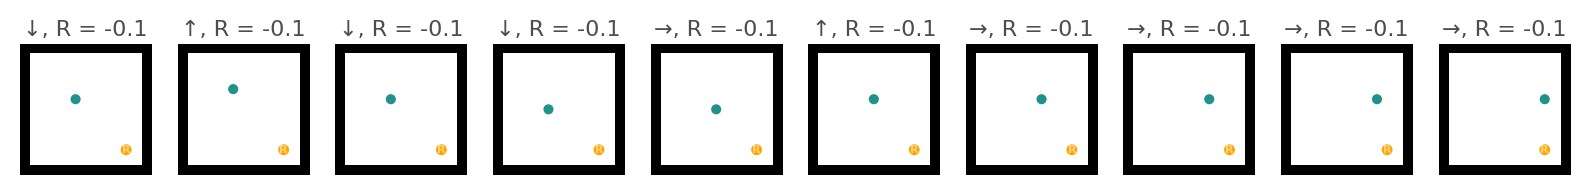

In [7]:
environment = MiniGrid(
    grid = grid,
    reward_locations = [(10,2),]
    )
fig, ax = plt.subplots(1,10, figsize=(10,1))
for i in range(10): # take 10 random actions and plot them 
    action = np.random.randint(0,4)
    state, reward, terminal = environment.step(action)
    ax[i] = environment.render(ax=ax[i])
    ax[i].set_title(f'{dict(enumerate(["↑", "→", "↓", "←"]))[action]}, R = {reward}')


> 📝 **Exercise 3.6**
> 
> 1. 🐍 Write a policy function which takes the Q-values of a state and returns the greedy action.
>

In [8]:
# Your code goes here
def epsilon_greedy_policy(Q_values, epsilon=0.1):
    """
    Q_values are the Q values for each possible action in the current state, shape = (n_actions,)
    epsilon is the probability of selecting a random action
    """
    raise NotImplementedError("You need to implement the policy method")

In [9]:
#@title Click to see solution {display-mode: "form" }
def epsilon_greedy_policy(Q_values, epsilon=0.1):
    """
    Q_values are the Q values for each possible action in the current state, shape = (n_actions,)
    epsilon is the probability of selecting a random action
    """
    n_actions = Q_values.shape[0]
    if np.random.rand() < epsilon:
        action = np.random.randint(0, n_actions)
    else:
        action = np.argmax(Q_values)
    return action

### **3.4.3 Training the grid world**

The following method trains a `TDQLearner` on the grid world environment. Make sure you understand how it works. This function is important, it wraps up everything we've learnt so far into a training loop:

1. An episode is started by resetting the environment and the agent's position.
2. An episode is performed until the agent reaches the goal or the maximum number of steps is reached:
    1. The agent chooses an action using the policy function and the `TDQLearner.Q` values.
    2. The agent takes the action and receives the next state and reward.
    3. The agent learns from the transition using the `TDQLearner.learn()` method.
3. Everything is saved for later plotting 

```python

> 📝 **Exercise 3.7**
>
> 1. 🐍 Complete the missing lines marked `# ????`


In [10]:
def train(
    self,
    tdqlearner, 
    n_episodes=1000,
    max_episode_length=100,
    policy=epsilon_greedy_policy,
    ): 

    for i in (pbar := tqdm(range(n_episodes))):

        try: # this just allows you to stop the loop by pressing the stop button in the notebook
            
            # Initialise an episode: 
            terminal = False
            self.reset() # reset the environment
            state = self.pos_to_state(self.agent_pos)
            action = policy(tdqlearner.Q[state])

            episode_data = {'positions': [], 'states':[], 'actions':[], 'rewards':[]}
            
            step = 0
            while not terminal and step < max_episode_length:
                # Get the next state and reward using the step() method
                # state_next, reward, terminal = ???? 
                
                # Get the next action using the policy() function
                # next_action = ????
                
                # Learn from the transition using the tdqlearner.learn() method
                # tdqlearner.learn( ???? 

                # store the data
                episode_data['positions'].append(self.agent_pos)
                episode_data['states'].append(state)
                episode_data['actions'].append(action)
                episode_data['rewards'].append(reward)

                # update the state and action
                state = state_next
                action = next_action 
                step += 1
            
            self.episode_history[minigrid.episode_number] = episode_data
            minigrid.episode_number += 1

        except KeyboardInterrupt:
            break

MiniGrid.train = train

In [11]:
#@title Click to see solution {display-mode: "form" }
def train(
    self,
    tdqlearner, 
    n_episodes=1000,
    max_episode_length=100,
    policy=epsilon_greedy_policy,
    ): 

    for i in (pbar := tqdm(range(n_episodes))):

        try: # this just allows you to stop the loop by pressing the stop button in the notebook
            
            # Initialise an episode: 
            terminal = False
            self.reset() # reset the environment
            state = self.pos_to_state(self.agent_pos)
            action = policy(tdqlearner.Q[state])

            episode_data = {'positions': [], 'states':[], 'actions':[], 'rewards':[]}
            
            step = 0
            while not terminal and step < max_episode_length:
                # Get the next state and reward using the step() method
                state_next, reward, terminal = self.step(action)
                if terminal: 
                    state_next = None
                    next_action = None
                else:
                    # Get the next action using the policy() function
                    next_action = policy(tdqlearner.Q[state_next])
                
                # Learn from the transition using the tdqlearner.learn() method
                tdqlearner.learn(state, state_next, action, next_action, reward)

                # store the data
                episode_data['positions'].append(self.agent_pos)
                episode_data['states'].append(state)
                episode_data['actions'].append(action)
                episode_data['rewards'].append(reward)

                # update the state and action
                state = state_next
                action = next_action 
                step += 1
            
            self.episode_history[self.episode_number] = episode_data
            self.episode_number += 1
            self.episode_lengths.append(step)

        except KeyboardInterrupt:
            break

MiniGrid.train = train

This code initialises an empty 20 x 20 grid world environment bounded by walls with a reward in the centre.

<Axes: >

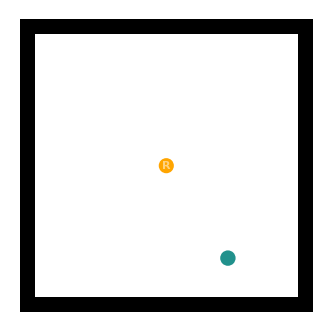

In [16]:
grid = np.array( # 0 = empty, 1 = wall
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ])

minigrid = MiniGrid(
    grid = grid,
    reward_locations = [(9,9),],
    reward_values = [10,]
    )

tdqlearner = TDQLearner(
    gamma=0.9, 
    alpha=0.2, 
    n_states=minigrid.n_states, 
    n_actions=minigrid.n_actions)

minigrid.render()

This code trains a `TDQLearner` on the grid world environment for 1000 episodes.

In [17]:
minigrid.train(
    tdqlearner, 
    n_episodes=500,
    max_episode_length=100,
    policy=lambda Q: epsilon_greedy_policy(Q, epsilon=0.1),)

100%|██████████| 500/500 [00:00<00:00, 4090.05it/s]


array([[<Axes: >, <Axes: >, <Axes: title={'center': 'First 5 episodes'}>,
        <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: title={'center': 'Last 5 episodes'}>,
        <Axes: >, <Axes: >]], dtype=object)

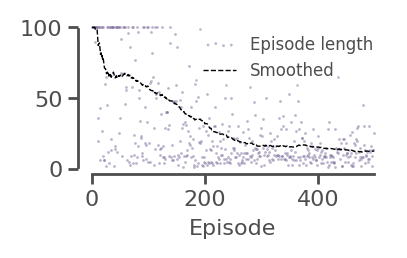

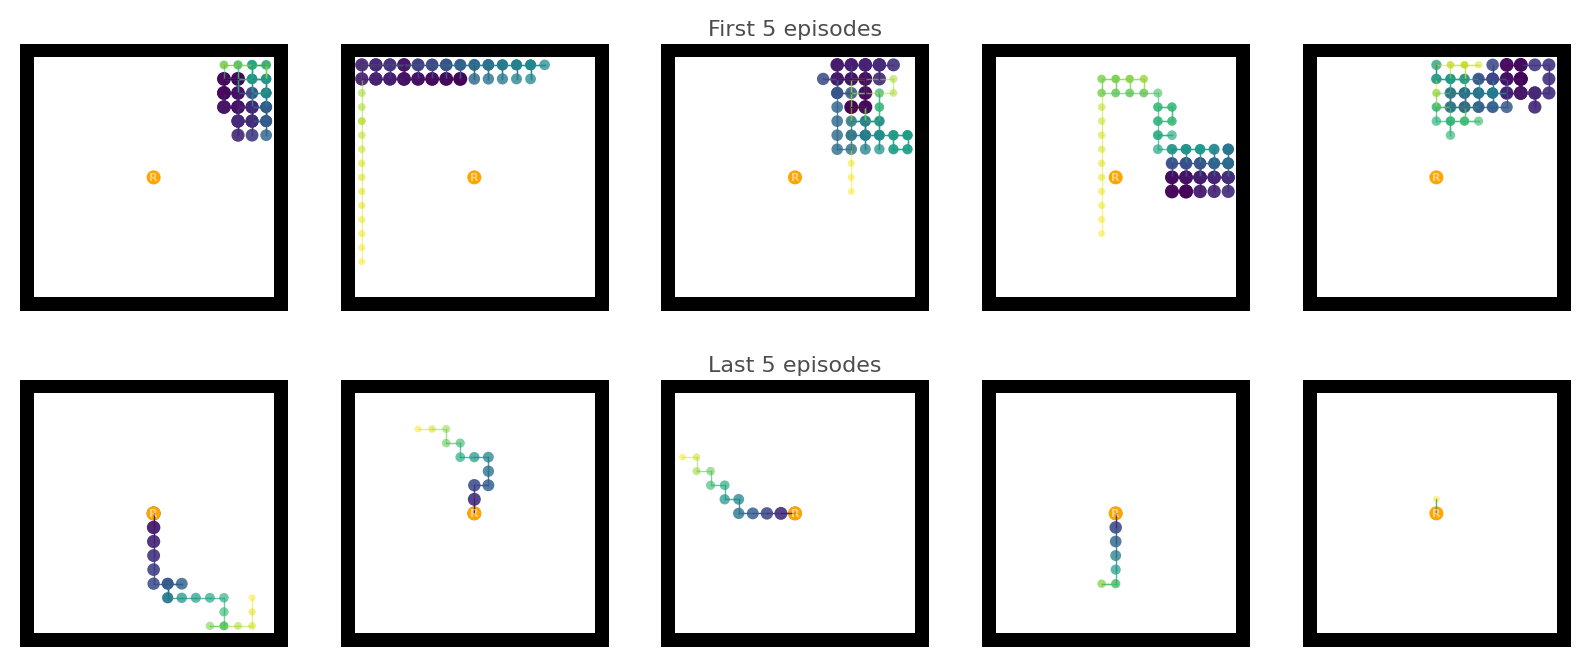

In [18]:
#@title Run this code to plot the training curve and first and last 5 episodes  {display-mode: "form" }
gridworldtraining_ax = minigrid.plot_training()
minigrid.plot_first_and_last_5_episodes()

> 📝 **Exercise 3.8**
>
> 1. By eye (or, if you wish, using the data available) calculate how long the algorithm took to converge as measured by how long before the episode length decay curve saturates. Your measurement does not need to be precise.

[<Axes: title={'center': 'Q(s,↑)'}>,
 <Axes: title={'center': 'Q(s,→)'}>,
 <Axes: title={'center': 'Q(s,↓)'}>,
 <Axes: title={'center': 'Q(s,←)'}>,
 <Axes: title={'center': 'π(s)'}>]

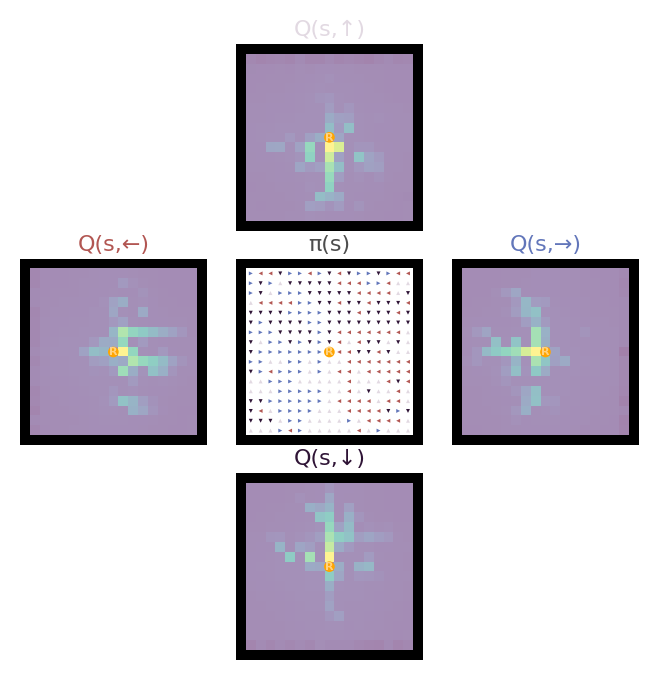

In [19]:
#@title Run this code to plot the Q values and optimal actions  {display-mode: "form" }
minigrid.plot_Q(tdqlearner.Q)

This final plot displays the Q-values of each state-action pair and, in the centre, the optimal (greedy) policy derived from the Q-values. 

> 📝 **Exercise 3.9**
> 
> With this code you should now be able to run quite a few experiments. 
> 1. 🐍 **Multiple rewards** Consider a long thin environment (say, 25 wide by 5 deep) with two rewards, one large ($R_1 = 15$ at $(x,y)=(2,2)$) and one small ($R_2 = 5$ at $(x,y)=(22,2)$) a distance $D = 20$ apart. Simulate this and see which reward the optimal agent approaches and from where (let $\gamma = 1$). _Note: simulate for 100,000 episodes to make sure the learning has converged._
>   - 💭 **[ADVANCED]** If the cost per step is $c = 1$ show that the optimal policy is to go towards the large reward up to a distance $D_{\textrm{switch}}$ otherwise go towards the small reward. Does this match what you find in simulation? 
> $$ D_{\textrm{switch}} = \frac{Dc - R_2 + R_1}{2c} = 15$$
> 2. 🐍 Experiment with a different policy generator, for example a stochastic policy generator such as softmax
> $$ P(A_t = a | S_t = s) = \frac{e^{Q(s, a) / \tau}}{\sum_{a'} e^{Q(s, a') / \tau}} $$
> 3. **[ADVANCED]** Train the agent on an environment where the reward is hidden behind a wall extending almost (but not quite) across the environment. Can the agent learn to navigate around the wall to the reward?
>     - 🐍 If a small gap in the wall is opened up after learning, test to see if the agent can easily learn to navigate through the gap to the reward.
>     - 💭 TO THINK What are the limitations of tabular Q-learning in this environment regarding generalisation to unseen states?
> 4. 💭 Imagine a much larger 100 x 100 environment: On different trials rewards can appear independently at five locations. Instead of just N, E, S, W the agent can move in any direction in 1 degree increments (i.e. 360 possible actions). Calculate the number of state-action pairs the agent would need to learn to solve this environment.
>     - 💭 TO THINK What are the limitations of tabular Q-learning in this environment regarding scale?

100%|██████████| 100000/100000 [00:04<00:00, 23577.72it/s]


[<Axes: title={'center': 'Q(s,↑)'}>,
 <Axes: title={'center': 'Q(s,→)'}>,
 <Axes: title={'center': 'Q(s,↓)'}>,
 <Axes: title={'center': 'Q(s,←)'}>,
 <Axes: title={'center': 'π(s)'}>]

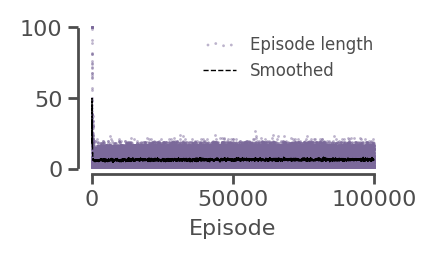

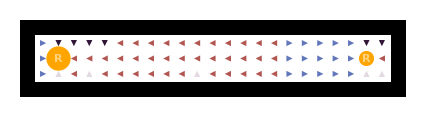

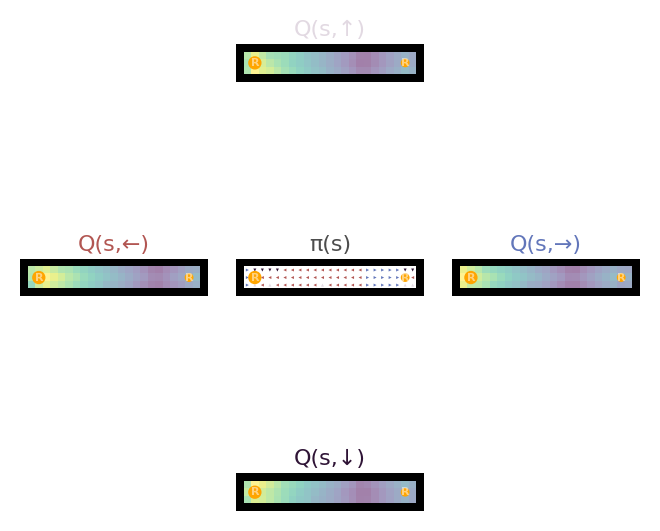

In [26]:
#@title Multiple rewards simulation  {display-mode: "form" }
grid = np.array( # 0 = empty, 1 = wall
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ])

minigrid_long = MiniGrid(
    grid = grid,
    reward_locations = [(2,2),(22,2)],
    reward_values = [15,5,],
    cost_per_step=1,
    cost_per_wall_collision=0,
    )

tdqlearner_long = TDQLearner(
    gamma=1.0, 
    alpha=0.1, 
    n_states=minigrid_long.n_states, 
    n_actions=minigrid_long.n_actions)

minigrid_long.train(tdqlearner_long, 
               n_episodes=100000, 
               policy=lambda Q: epsilon_greedy_policy(Q, epsilon=0.05),)

minigrid_long.plot_training()

# Plot Q values along central row and see where west and east cross 
minigrid_long.plot_policy(tdqlearner_long.Q)   
minigrid_long.plot_Q(tdqlearner_long.Q)


In [ ]:
#@title Solution to the hiding-a-reward-behind-the-wall  {display-mode: "form" }
grid = np.array( # 0 = empty, 1 = wall
    [
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    ])

minigrid_wall = MiniGrid(
    grid = grid,
    reward_locations = [(14,2),],
    reward_values = [10,]
    )

tdqlearner_wall = TDQLearner(
    gamma=0.9, 
    alpha=0.2, 
    n_states=minigrid_wall.n_states, 
    n_actions=minigrid_wall.n_actions)


# Train like normal 
minigrid_wall.train(tdqlearner_wall, 
               n_episodes=1000, 
               policy=lambda Q: epsilon_greedy_policy(Q,epsilon=0.1))
minigrid_wall.plot_training()
ax = minigrid_wall.plot_Q(tdqlearner_wall.Q)
ax[0].get_figure().suptitle("Policy before a wall is removed")

# Make a gap in the wall and train for another 100 episodes 
minigrid_wall.grid[15,12] = 0
minigrid_wall.train(tdqlearner_wall, 
               n_episodes=1000, 
               policy=lambda Q: epsilon_greedy_policy(Q,epsilon=0.1))
minigrid_wall.plot_training()
ax = minigrid_wall.plot_Q(tdqlearner_wall.Q)
ax[0].get_figure().suptitle("Policy after a wall is removed")

---
## **4. State features and function approximation** <a name="dqn"></a>

In this section we'll set ourselves free from the limitation that _every state-action pair_ must be stored in a table. Instead we'll learn a continuous function which maps states to Q-values. 

We'll call this function the _Q-function_. It will take in the state and returns a vector of Q-values for each action. 

$$\hat{Q}_{\theta}(s,a) $$

Where $\theta$ are the parameters of the function. We'll learn these parameters using the SARSA algorithm._

### **4.1 State features vs states?**<a name="statefeatures"></a>

Another change we'll make is that instead of passing the state directly into the Q-function as we did before, we'll pass a _feature vector_ of the state. 

$$ s \rightarrow \mathbf{\phi}(s) = [\phi_1(s), \phi_2(s), \ldots, \phi_{N_f}(s)]^{\top} $$

In our case the "state" is fully described by the position of the agent in the grid world, so: 

$$ s \rightarrow \mathbf{\phi}(\mathbf{x}) = [\phi_1(\mathbf{x}), \phi_2(\mathbf{x}), \ldots, \phi_{N_f}(\mathbf{x})]^{\top} $$

There are a number of benefits to this:
1. **Generalisation**: The function can generalise to unseen states which are similar to states it has seen before. This is because is if $\mathbf{\phi}(\mathbf{x})$ is close to $\mathbf{\phi}(\mathbf{x}^{\prime})$ then $\hat{Q}_{\theta}(\mathbf{x})$ will be close to $\hat{Q}_{\theta}(\mathbf{x}^{\prime})$. _Before_, if a state was unseen the agent would have no idea what to do.
2. **Biological plausibility**: The brain is thought to represent states using feature vectors. Famous examples in the navigation domain include: 
    - **Place cells** in the hippocampus fire when an animal is in a particular location.
    - **Grid cells** in the entorhinal cortex fire in a hexagonal grid pattern across the environment.
    - **Boundary Vector Cells** in thesubiculum fire when an animal is near a boundary / wall. 
    - **Head direction cells** in the thalamus fire when an animal is facing a particular direction.
3. **Dimensionality reduction**: The feature vector can be much smaller than the state space. For example, in a grid world with 1000000 "states", a well-designed feature vector might only have have 100 features.
4. **Feature engineering**: We can design the feature vector to encode, _a priori_, domain knowledge about the environment. For example: 
    - In a RL task where the inputs are words, we should encode the words as word embeddings (aka. feature vectors). It would be sensible to encode similar words as similar vectors for example "cat" and "feline" should be close in the feature space. Anything we then learn about "cat" should quickly generalise to "feline".
    - In the grid world we might use states features which are continuous in space (e.g. smooth place cells). That way if we learn that position $(x,y)$ is good we can quickly generalise to $(x+\delta_x, y+\delta_y)$.

<center><img src="./figures/neuro_statefeatures.png" width=1000></center>

> 📝 **Exercise 4.1**
>
> 1. 💭 TO THINK Think of some more _inductive biases_ it might be useful to useful to build into the feature vectors for a spatial navigation task. 


> 📝 **Exercise 4.2 [ADVANCED]**
>
> 1. 💭 Starting from the loss function $L_t(\theta) = (Q_{\pi}(s,a) - \hat{Q}(s, a; \theta))^2$ show that the bootstrapped update rule for $\theta$ is $\theta \leftarrow \theta + \alpha \delta_t \nabla_{\theta} \hat{Q}(s, a; \theta)$ where $\delta_t = R_{t+1} + \gamma \hat{Q}(S_{t+1}, A_{t+1}; \theta) - \hat{Q}(S_t, A_t; \theta)$ is the bootstrapped TD-error.
> 2. 💭 Hence show for a linear Q-function $\hat{Q}(s, a; \theta) = \theta^{\top} \mathbf{\phi}(s)$ the optimal update rule is $\theta \leftarrow \theta + \alpha \delta_t \mathbf{\phi}(s)$. 

### **4.2 Continuous positions _but_ discrete actions**
Position is now a continuous variable. So instead of `minigrid.agent_pos = (3,4)` ("the agent is 3 grids from the left, 4 from the bottom") its now `minigrid.agent_pos = (0.223,0.186)` ("the agent is 0.223 m from the left and 0.186 m from the bottom"). 

Actions are still discrete but now we'll also allow diagonal movements too (for no particular reason).  
- `0` = "North", `1` = "North-East", `2` = "East", `3` = "South-East", `4` = "South", `5` = "South-West", `6` = "West", `7` = "North-West".

> 📝 **Exercise 4.3**
>
> 1. 💭 TO THINK Do you think it would be possible to have a _continuous_ action space? _Hint: think about any difficulties you might encounter calculating the greedy action._

### **4.3 Changes to the python code**

There are two key changes which need to be made: 
1. The `environment` is no longer a `MiniGrid` (discretised) but a `MiniSpace` (continuous). This has already been written for you, the API is almost identical to that of `MiniGrid`.
2. The TD learner class _[TO BE WRITTEN BY  YOU]_ has a `self.Q(state, action)` function (rather than a `self.Q[state, action]` table) which takes a state and action as input and returns the Q-value.

We'll be using the `RatInABox` (George et al. 2024, https://github.com/RatInABox-Lab/RatInABox) package to handle creating continuous environments and generating biological state features. The following code shows how to make an `Environment`, in which there will be an `Agent` who state is encoded through the firing rate of some `state_features` (any `RatInABox.Neurons` object). Then all three of these are passed into the `MiniSpace` which handles the RL side of things. 

```python 
minispace = MiniSpace(
    env = env, 
    ag = ag, 
    state_features = state_features, 
    reward_locations=[(0.5,0.3)], 
    reward_values=[1000,], 
    )
```


In [ ]:
# Import RatInABox modules
from ratinabox.Environment import Environment 
from ratinabox.Agent import Agent 
from ratinabox.Neurons import PlaceCells, GridCells

# Make a 2D environment, the default size is 1m x 1m
env = Environment(params={'dx':0.04})
# Add a wall 
env.add_wall([[0.2,0.5],[0.8,0.5]])
# Add an Agent who position in the environment determines the "state"
ag = Agent(env)
# Make "state features" which are the place cells, grid cells etc. 
state_features_placecells = PlaceCells(ag, params={'n':100, 'widths':0.08})
state_features_gridcells = GridCells(ag, params={'n':100, 'gridscale_distribution':'uniform', 'gridscale':(0.1,0.4)})

# Plot
state_features_placecells.plot_rate_map(chosen_neurons='8')
state_features_gridcells.plot_rate_map(chosen_neurons='8')

### **4.4 Linear Q-function**<a name="linearq"></a

We'll start by learning a linear Q-function. This is a simple function which takes the dot product of the feature vector and a weight vector.

$$ \hat{Q}_{\mathsf{W}}(s, a) = [\mathsf{W}^{\top} \mathbf{\phi}(s)]_{a} $$

Here $W \in \mathbb{R}_{N_f \times N_a}$ is the weight matrix and $[\cdot]_a$ denotes the $a$-th element of the vector.

> 📝 **Exercise 4.4**
>
> 1. 🐍 Complete the `Q` function in the `LinearTDQLearner` class below.


In [ ]:
class LinearTDQLearner():
    def __init__(self, gamma=0.5, alpha=0.1, n_features=10, n_actions=8):
        self.gamma = gamma
        self.alpha = alpha
        self.n_features = n_features
        
        # Initialize the weights
        self.W = np.zeros((n_features, n_actions))

    def Q(self, state, action=None):
        """
        This function should return the Q value for a given state and action
        State should be a vector of features. Optionally it can be a batch of states where the batch dimension is the first dimension.
        If action is None then the function should return the Q values for all actions in the state.
        """
        # append one to the state to account for the bias term
        Q_values = np.dot(state, self.W)
        return Q_values[...,action] if action is not None else Q_values
    
    def learn(self, S, S_next, A, A_next, R):
        # Get's the value of the current and next state
        Q = self.Q(S,A) if S is not None else 0
        Q_next = self.Q(S_next, A_next) if S_next is not None else 0
        
        # Gradient of the Q value with respect to the weights
        dQdW = None # ???
        # Calculates the TD error (hint remember to use self.gamma
        TD_error = None# ???

        # Updates the value of the current state
        if S is not None:
            self.W[:,A] = self.W[:,A] + self.alpha * TD_error * dQdW 


In [ ]:
#@title Click to see solution {display-mode: "form" }
class LinearTDQLearner():
    def __init__(self, gamma=0.5, alpha=0.1, n_features=10, n_actions=8):
        self.gamma = gamma
        self.alpha = alpha
        self.n_features = n_features
        
        # Initialize the weights
        self.W = np.zeros((n_features, n_actions))

    def Q(self, state, action=None):
        """
        This function should return the Q value for a given state and action
        State should be a vector of features. Optionally it can be a batch of states where the batch dimension is the first dimension.
        If action is None then the function should return the Q values for all actions in the state.
        """
        # append one to the state to account for the bias term
        Q_values = np.dot(state, self.W)
        return Q_values[...,action] if action is not None else Q_values
    
    def learn(self, S, S_next, A, A_next, R):
        # Get's the value of the current and next state
        Q = self.Q(S,A) if S is not None else 0
        Q_next = self.Q(S_next, A_next) if S_next is not None else 0
        
        # Gradient of the Q value with respect to the weights
        dQdW = S# ???
        # Calculates the TD error (hint remember to use self.gamma
        TD_error = R + self.gamma * Q_next - Q

        # Updates the value of the current state
        if S is not None:
            self.W[:,A] = self.W[:,A] + self.alpha * TD_error * dQdW - 0.01 * self.alpha * self.W[:,A] # L2 regularisation

Make the `MiniSpace`. For the `state_features` we'll be using the place cells we created a few boxes earlier but later you can experiment with others. 

In [ ]:
env = Environment()
ag = Agent(env)
state_features = PlaceCells(ag, params={'n':100, 'widths':0.08})

minispace = MiniSpace(
    env = env, 
    ag = ag, 
    state_features = state_features, 
    reward_locations=[(0.5,0.5)], 
    reward_values=[10,], 
    )

lineartdqlearner = LinearTDQLearner(
    gamma=0.95, 
    alpha=0.2, 
    n_features=state_features.n,
    n_actions=minispace.n_actions)

In [ ]:
minispace.train(lineartdqlearner,
            n_episodes=500,
            policy=lambda Q: epsilon_greedy_policy(Q,epsilon=0.05))
minispace.plot_training()

> 📝 **Exercise 4.5**
> 
> 1. 🐍 By eye or otherwise, does this SARSA algorithm with place cell state features learn faster or slower than the gridworld (in terms of the number of episodes, not total compute). 
> 2. 💭 Discuss the reasons for this. _Hint: consider how place cells are broad and diffuse and what this implies about the generalisation of the value function._

In [ ]:
minispace.plot_Q(lineartdqlearner.Q)
minispace.plot_first_and_last_5_episodes()

> 📝 **Exercise 4.6**
>
> 1. 💭 Discuss with your partner the following questions: 
>     - The peaks of the Q-value maops for each action are in different locations. Why is this?
>     - What is the optimal policy?

> 📝 **Exercise 4.7**
>
> 1. 🐍 Experiment with different state features. For example, try using a `GridCells` instead of `PlaceCells`. Does learning succeed? What about a grid of place cells with a different spacing? If not, what does this tell us about the limitations of _linear_ Q-functions. 
> 2. 💭 Next try and massively increase the number of grid cells to 1000. Does learning improve? 
> 3. 💭 **TO THINK** Considered the multimodal shape of grid cell receptive fields, think about why _more_ grid cells are needed than place cells. 

_Note: In tomorrow's class you'll learn more about grid cells and their proposed role in the brain._

In [ ]:
#@title Click to see solution for grid cells {display-mode: "form" }
env = Environment()
ag = Agent(env)
state_features = GridCells(ag, params={'n':1000, 'gridscale_distribution':'uniform', 'gridscale':(0.1,0.4)})

minispace = MiniSpace(
    env = env, 
    ag = ag, 
    state_features = state_features, 
    reward_locations=[(0.5,0.5)], 
    reward_values=[10,], 
    )

lineartdqlearner = LinearTDQLearner(
    gamma=0.95, 
    alpha=0.01, 
    n_features=state_features.n,
    n_actions=minispace.n_actions)

minispace.train(lineartdqlearner,
            n_episodes=500,
            policy=lambda Q: epsilon_greedy_policy(Q,epsilon=0.0))
minispace.plot_training()

minispace.plot_Q(lineartdqlearner.Q)
minispace.plot_first_and_last_5_episodes()

> 📝 **Exercise 4.7 [ADVANCED]**
> 
>    Here are some ideas of extended projects you might like to work on: 
> 1. 🐍Rewrite the `LinearTDQLearner` class to `DNNTDQLearner` which uses a `pytorch` neural network to approximate the Q-function.
> 2. 💭 **ΤΟ ΤΗΙΝΚ** Can you think of a task where linear function approximation is guaranteed to fail. _Hint: consider tasks where features interact in complex ways._
> 3. 🐍 Make a 

---

## **Congrats!**
Well done. You made it to the end of the tutorial! Solution may or may not have been given to you in a seperate `solutions.ipynb` notebook.

### **Re-use**
Feel free you to adapt and use this tutorial for your own teaching need! 

* Feel free to get in touch at tom.george.20@ucl.ac.uk 
* Links: [Twitter](https://twitter.com/TomNotGeorge), [Github](https://github.com/TomGeorge1234), [Google Scholar](https://scholar.google.com/citations?user=AG49j3MAAAAJ&hl=en)

